In [ ]:
%pip install opendatasets
import opendatasets as od

od.download('https://www.kaggle.com/datasets/mohammedalrajeh/quran-recitations-for-audio-classification')

In [ ]:
%pip install torch
%pip install torchvision
%pip install torchsummary
%pip install numpy==2.1.2
%pip install pandas
%pip install matplotlib
%pip install scikit-learn
%pip install pillow
%pip install librosa
%pip install scikit-image

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa

from torch import nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision.transforms import transforms
from sklearn.preprocessing import LabelEncoder
from skimage.transform import resize

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

In [3]:
df = pd.read_csv('./quran-recitations-for-audio-classification/files_paths.csv')
df.head()


,FilePath,Class
0,./Dataset/Mohammed_Aluhaidan/lohaidan_171.wav,Mohammed_Aluhaidan
1,./Dataset/Mohammed_Aluhaidan/lohaidan_159.wav,Mohammed_Aluhaidan
2,./Dataset/Mohammed_Aluhaidan/lohaidan_401.wav,Mohammed_Aluhaidan
3,./Dataset/Mohammed_Aluhaidan/lohaidan_367.wav,Mohammed_Aluhaidan
4,./Dataset/Mohammed_Aluhaidan/lohaidan_373.wav,Mohammed_Aluhaidan


In [4]:
df = pd.read_csv('./quran-recitations-for-audio-classification/files_paths.csv')
df['FilePath'] = './quran-recitations-for-audio-classification/Dataset' + df['FilePath'].str[1:]
df.head()

,FilePath,Class
0,./quran-recitations-for-audio-classification/D...,Mohammed_Aluhaidan
1,./quran-recitations-for-audio-classification/D...,Mohammed_Aluhaidan
2,./quran-recitations-for-audio-classification/D...,Mohammed_Aluhaidan
3,./quran-recitations-for-audio-classification/D...,Mohammed_Aluhaidan
4,./quran-recitations-for-audio-classification/D...,Mohammed_Aluhaidan


In [5]:
print('Data Shape: ', df.shape)
print('Class Distribution: ', df['Class'].value_counts())

Data Shape:  (6687, 2)
Class Distribution:  Class
Saud_Alshuraim          696
Saad_Alghamdi           688
AbdulRahman_Alsudais    648
Yasser_Aldossary        576
Maher_Almuaiqly         576
Bander_Balilah          576
Ali_Alhothaify          576
Abdullah_Albuaijan      504
Mohammed_Ayoub          480
Nasser_Alqutami         456
AbdulBari_Althubaity    456
Mohammed_Aluhaidan      455
Name: count, dtype: int64


Text(0.5, 1.0, 'Class Distribution')

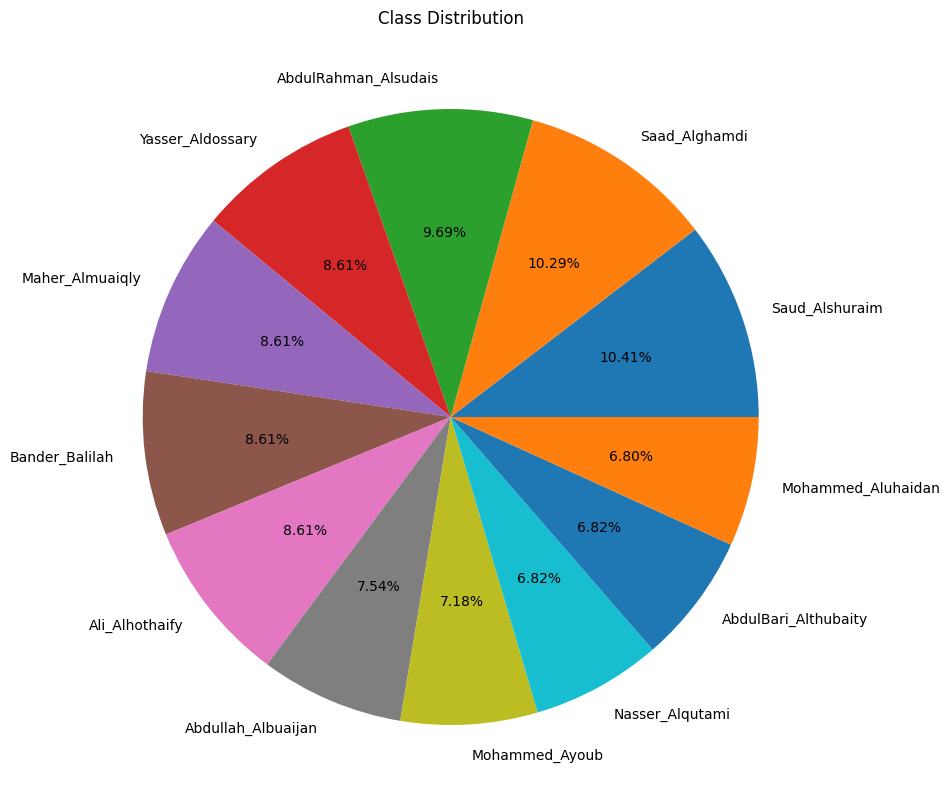

In [6]:
plt.figure(figsize=(10, 10))
plt.pie(df['Class'].value_counts(), labels=df['Class'].value_counts().index, autopct='%.2f%%')
plt.title('Class Distribution')

In [7]:
label_encoder = LabelEncoder()
df['Class'] = label_encoder.fit_transform(df['Class'])

train_data = df.sample(frac=0.7, random_state=42)
test_data = df.drop(train_data.index)

val_data = test_data.sample(frac=0.5, random_state=42)
test_data = test_data.drop(val_data.index)

In [8]:
train_data.shape, test_data.shape, val_data.shape

((4681, 2), (1003, 2), (1003, 2))

In [9]:
class CustomAudioDataset(Dataset):
    def __init__(self, data):
        super(CustomAudioDataset, self).__init__()
        self.data = data
        self.labels = torch.Tensor(list(data['Class'])).type(torch.long)
        self.audios = [torch.Tensor(CustomAudioDataset.get_spectrogram(path)).type(torch.float) for path in
                       data['FilePath']]

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        label = torch.Tensor(self.labels[index])
        audio = self.audios[index].unsqueeze(0)
        return audio, label

    @staticmethod
    def get_spectrogram(path):
        sr = 22058
        duration = 5

        img_height = 128
        img_width = 256

        signal, sr = librosa.load(path, sr=sr, duration=duration)
        spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
        spec_db = librosa.power_to_db(spec, ref=np.max)

        spec_resized = librosa.util.fix_length(spec_db, size=(duration * sr) // 512 + 1)
        spec_resized = resize(spec_resized, (img_height, img_width), anti_aliasing=True)
        return spec_resized

In [10]:
train_dataset = CustomAudioDataset(train_data)
test_dataset = CustomAudioDataset(test_data)
val_dataset = CustomAudioDataset(val_data)

In [11]:
LR = 1e-3
BATCH_SIZE = 4
EPOCHS = 10

In [12]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [16]:
df_class_count = len(df['Class'].unique())

class ViewResize(nn.Module):
    def __init__(self):
        super(ViewResize, self).__init__()

    def forward(self, x):
        return x.view(x.size(0), -1)


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            nn.ReLU(),

            ViewResize(),

            nn.Flatten(),

            nn.Linear(in_features=32768, out_features=4096),
            nn.Dropout(p=0.5),

            nn.Linear(in_features=4096, out_features=1024),
            nn.Dropout(p=0.5),

            nn.Linear(in_features=1024, out_features=512),
            nn.Dropout(p=0.5),

            nn.Linear(in_features=512, out_features=df_class_count),
        )

    def forward(self, x):
        return self.seq(x)


In [17]:
model = Net().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

In [ ]:
total_loss_train_plot = []
total_loss_val_plot = []
total_acc_train_plot = []
total_acc_val_plot = []

for epoch in range(EPOCHS):
    total_loss_train = 0
    total_loss_val = 0
    total_acc_train = 0
    total_acc_val = 0


    for inputs, labels in train_loader:
        optimizer.zero_grad()

        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        train_loss = loss_fn(outputs, labels)

        train_loss.backward()
        optimizer.step()

        total_loss_train += train_loss.item()
        total_acc_train += labels.eq(outputs.argmax(dim=1)).sum().item()

    with torch.inference_mode():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            total_loss_val += loss_fn(outputs, labels).item()
            total_acc_val += labels.eq(outputs.argmax(dim=1)).sum().item()

    total_loss_train_plot.append(round(total_loss_train / 1000, 4))
    total_loss_val_plot.append(round(total_loss_val / 1000, 4))

    total_acc_train_plot.append(round(total_acc_train / train_dataset.__len__() * 100, 4))
    total_acc_val_plot.append(round(total_acc_val / val_dataset.__len__() * 100, 4))


    print(f'Epoch {epoch + 1}/{EPOCHS}, train_loss: {total_loss_train_plot[-1]}, train_acc: {total_acc_train_plot[-1]}, val_loss: {total_loss_val_plot[-1]}, val_acc: {total_acc_val_plot[-1]}')